# 0. Run Jaris and Roshni's scripts

### 0.1 Run preprocessing scripts to get X and y

In [3]:
# %run data_preprocessing_Jaris.ipynb
# %run data_preprocessing_Jaris_test.ipynb
%run SignFlow.ipynb
import cv2


2023-11-27 10:06:23.484857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 10:06:25.304776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benleng/.pyenv/versions/3.10.6/envs/SignFlow/lib/python3.10/site-packages/cv2/../../lib64:
2023-11-27 10:06:25.304906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-27 10:06:25.552963: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plug

✅ X has been initialized with Shape (63, 10, 150, 150, 3)!
✅ y has been initialized with Shape (63, 6)!

✅ X_aug has been initialized with Shape (176, 10, 150, 150, 3)!
✅ y_aug has been initialized with Shape (176, 6)!

✅ X_val has been initialized with Shape (19, 10, 150, 150, 3)!
✅ y_cat_val has been initialized with Shape (19, 6)!


In [8]:
X = X_aug
print(X.shape)
# y = y_cat
y = y_aug
print(y.shape)


(176, 10, 150, 150, 3)
(176, 6)


### 0.2 Play videos

In [5]:
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file at {video_path}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow('Video Playback', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [13]:
selected_words = ['hello',
'bye',
'world',
'yes',
'no',
'I',
'you',
'go',
'work',
'drink',
'beer',
'many',
'what',
'thank you',
'love']
print(len(selected_words))


15


In [61]:
word = selected_words[14]
video_list = list(features_df[features_df["word"] == word]["video_id"] + ".mp4")
len(video_list)
video_list


['34123.mp4',
 '34124.mp4',
 '34127.mp4',
 '34128.mp4',
 '34129.mp4',
 '34121.mp4',
 '34137.mp4']

In [62]:
video_dir = "../data/videos/"

# Replace 'video_path' with the path to your video file
for i in range (len(video_list)):
    video_path = video_dir + video_list[i]
    video_path
    play_video(video_path)


In [ ]:
# A
# family
# cold
# hot

# B
# bad
# good

# C
# dog
# doctor
# apple
# far
# yesteday


# D
# computer


# 1. Import libraries

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import json
import os
import cv2


In [ ]:
input_shape=(150,150,3)


In [ ]:
# def add_final_layers(base_model):
#     model = Sequential()
#     model.add(base_model)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(10, activation="relu"))
#     model.add(layers.Reshape((-1,10)))
#     model.add(layers.SimpleRNN(units=10, activation="tanh", return_sequences=True))
#     model.add(layers.SimpleRNN(units=5, activation="tanh", return_sequences=True))
#     model.add(layers.Dense(20, activation="softmax"))
#     return model


# 2. Load MobileNet

### 1.1 MobileNet

In [ ]:
def load_model_1():
    model = MobileNet(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling='avg',  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classificatio
    )
    return model

model_mobilenet = load_model_1()
model_mobilenet.trainable = False


In [ ]:
model_mobilenet.summary()
# model_mobilenet.layers


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [ ]:
layers_outputs = [layer.output for layer in model_mobilenet.layers]
layers_outputs


[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_13')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1_relu')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1_relu')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1_relu')>,
 <KerasTensor: shape=(None, 76, 76, 64) dtype=float32 (created by layer 'conv_pad_2')>,
 <KerasTensor: shape=(None, 37

### 1.2 MobileNetV2

In [ ]:
def load_model_2():
    model = MobileNetV2(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling='avg',  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classificatio
    )
    return model

model_mobilenetv2 = load_model_2()
model_mobilenetv2.trainable = False


In [ ]:
model_mobilenetv2.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_14[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

### 1.3 MobileNetv3Small

In [ ]:
def load_model_3small():
    model = MobileNetV3Small(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling="avg",  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classification
    )
    return model

model_mobilenetv3small = load_model_3small()
model_mobilenetv3small.trainable = False


In [ ]:
model_mobilenetv3small.summary()


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 75, 75, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 75, 75, 16)  64          ['Conv[0][0]']    

### 1.4 MobileNetV3Large

In [ ]:
def load_model_3large():
    model = MobileNetV3Large(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling='avg',  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classificatio
    )
    return model

model_mobilenetv3large = load_model_3large()
model_mobilenetv3large.trainable = False


In [ ]:
model_mobilenetv3large.summary()


Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 75, 75, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 75, 75, 16)  64          ['Conv[0][0]']    

### 1.5 VGG16

In [ ]:
def load_model_vgg16():
    model = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=input_shape,
                  pooling='avg')
    return model

model_vgg16 = load_model_vgg16()
model_vgg16.trainable = False


In [ ]:
model_vgg16.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 1.6 ResNet50

In [ ]:
def load_model_resnet50():
    model = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=input_shape,
                  pooling='avg')
    return model

model_resnet50 = load_model_resnet50()
model_resnet50.trainable = False


In [ ]:
model_resnet50.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# 3. Define RNN and Compile

In [ ]:
dim = 1024


In [ ]:
def model_initialize_simple(dim):
    model = Sequential()
    model.add(layers.SimpleRNN(units=256, activation="tanh", input_shape=(10,dim), return_sequences=True))
    model.add(layers.SimpleRNN(units=128, activation="tanh"))
    model.add(layers.Dense(6, activation="softmax"))
    return model

model = model_initialize_simple(dim)
model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_38 (SimpleRNN)   (None, 10, 256)           327936    
                                                                 
 simple_rnn_39 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_36 (Dense)            (None, 6)                 774       
                                                                 
Total params: 377,990
Trainable params: 377,990
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate = 1e-4

def model_compile(model):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    return model

model = model_compile(model)


# 4. Dry run on sample (OLD - ignore now)

### 4.1 Prepare X

In [ ]:
# import cv2
# X_sample = [[],[]]

# for i in range(1,3):
#     image = cv2.imread(f'../data_test/X{i}.jpg')

#     width, height = 256, 256
#     resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

#     #produce resized jpy
#     cv2.imwrite(f'../data_test/X{i}_resized.jpg', resized_image)

#     #produce matrix and input into X
#     image_matrix = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
#     for j in range(10):
#         X_sample[i-1].append(image_matrix)


In [ ]:
# plt.imshow(X_sample[0][3])


In [ ]:
# X_features = []

# for i in range(len(X)):
#     features = model_mobilenet.predict(X[i])
#     X_features.append(features)

# features.shape


In [ ]:
# X_features = tf.convert_to_tensor(X_features)
# X_features.shape


### 4.2 Prepare y

In [ ]:
# # y = ["like", "like"]
# y = [3, 1]
# y = to_categorical(y, num_classes=20)
# y.shape


# 5.1 Train/val split (for MobileNet only)

In [ ]:
X_aug_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_aug)
print(X_aug_preprocessed.shape)

X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
print(X_val_preprocessed.shape)


(924, 10, 150, 150, 3)
(19, 10, 150, 150, 3)


In [ ]:
X_aug_features = []
X_val_features = []

for i in range(len(X_aug_preprocessed)):
    features = model_mobilenet.predict(X_aug_preprocessed[i])
    X_aug_features.append(features)

for i in range(len(X_val_preprocessed)):
    features = model_mobilenet.predict(X_val_preprocessed[i])
    X_val_features.append(features)


# features.shape


1/1 [==============================] - 0s 56ms/step


In [ ]:
print(len(X_aug_features))
print(X_aug_features[63].shape)

print(len(X_val_features))
print(X_val_features[18].shape)


924
(10, 1024)
19
(10, 1024)


In [ ]:
print(y_aug.shape)
print(y_cat_val.shape)
#new


(924, 6)
(19, 6)


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X_features, y, train_size=0.7, random_state=1, stratify=y)


In [ ]:
X_aug_features = tf.convert_to_tensor(X_aug_features)
print(X_aug_features.shape)
X_val_features = tf.convert_to_tensor(X_val_features)
print(X_val_features.shape)


(924, 10, 1024)
(19, 10, 1024)


In [ ]:
# y_val.mean(axis=0)


array([0.19143577, 0.17380352, 0.15869017, 0.15869017, 0.15869017,
       0.15869017], dtype=float32)

In [ ]:
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(
    X_aug_features,
    y_aug,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_features, y_cat_val),
    verbose=1,
    callbacks=[es]
)


Epoch 1/100
58/58 [==============================] - 1s 12ms/step - loss: 1.4582 - accuracy: 0.4416 - val_loss: 2.0232 - val_accuracy: 0.2105
Epoch 2/100
58/58 [==============================] - 1s 9ms/step - loss: 0.7044 - accuracy: 0.8604 - val_loss: 2.1659 - val_accuracy: 0.1579
Epoch 3/100
58/58 [==============================] - 0s 9ms/step - loss: 0.3653 - accuracy: 0.9610 - val_loss: 2.2889 - val_accuracy: 0.1579
Epoch 4/100
58/58 [==============================] - 1s 9ms/step - loss: 0.2032 - accuracy: 0.9881 - val_loss: 2.2661 - val_accuracy: 0.2105
Epoch 5/100
58/58 [==============================] - 1s 9ms/step - loss: 0.1236 - accuracy: 0.9989 - val_loss: 2.3101 - val_accuracy: 0.2632
Epoch 6/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 1.0000 - val_loss: 2.4082 - val_accuracy: 0.2105
Epoch 7/100
58/58 [==============================] - 0s 8ms/step - loss: 0.0566 - accuracy: 1.0000 - val_loss: 2.4322 - val_accuracy: 0.2632
Epoch 8/100


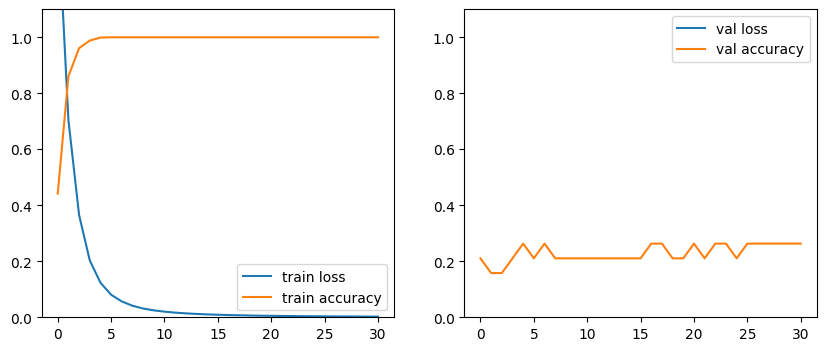

In [ ]:
def plot_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    ax1.plot(history.__dict__["history"]["loss"], label="train loss")
    ax1.plot(history.__dict__["history"]["accuracy"], label="train accuracy")
    ax1.legend()
    ax1.set_ylim(0,1.1)

    ax2.plot(history.__dict__["history"]["val_loss"], label="val loss")
    ax2.plot(history.__dict__["history"]["val_accuracy"], label="val accuracy")
    ax2.legend()
    ax2.set_ylim(0,1.1)

plot_accuracy(history)


# 5.2 Train with various CNN models

In [ ]:
X.shape


(219, 10, 150, 150, 3)

In [ ]:
# Make a table to loop through
results = pd.DataFrame(columns=["model", "input_shape", "accuracy"])
results["model"] = ("MobileNet", "MobileNetV2", "MobileNetV3Small", "MobileNetV3Large", "VGG16", "ResNet50")
results["input_shape"] = (
    model_mobilenet.layers[-1].output.shape[1],
    model_mobilenetv2.layers[-1].output.shape[1],
    model_mobilenetv3small.layers[-1].output.shape[1],
    model_mobilenetv3large.layers[-1].output.shape[1],
    model_vgg16.layers[-1].output.shape[1],
    model_resnet50.layers[-1].output.shape[1],
)
results


,model,input_shape,accuracy
0,MobileNet,1024,NaN
1,MobileNetV2,1280,NaN
2,MobileNetV3Small,576,NaN
3,MobileNetV3Large,960,NaN
4,VGG16,512,NaN
5,ResNet50,512,NaN


In [ ]:
dict_models = {
    "MobileNet": load_model_1(),
    "MobileNetV2": load_model_2(),
    "MobileNetV3Small": load_model_3small(),
    "MobileNetV3Large": load_model_3large(),
    "VGG16": load_model_vgg16(),
    "ResNet50": load_model_resnet50(),
}

dict_preprocessors = {
    "MobileNet": tf.keras.applications.mobilenet.preprocess_input,
    "MobileNetV2": tf.keras.applications.mobilenet_v2.preprocess_input,
    "MobileNetV3Small": tf.keras.applications.mobilenet_v3.preprocess_input,
    "MobileNetV3Large": tf.keras.applications.mobilenet_v3.preprocess_input,
    "VGG16": tf.keras.applications.vgg16.preprocess_input,
    "ResNet50": tf.keras.applications.resnet50.preprocess_input,
}


In [ ]:
results['input_shape'][0].astype(int)


1024

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)


✅ (Run 1) got X_features
✅ (Run 1) defined RNN and compile
✅ (Run 1) RNN is now fit
✅ MobileNet completed


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


✅ (Run 2) got X_features
✅ (Run 2) defined RNN and compile
✅ (Run 2) RNN is now fit
✅ MobileNetV2 completed


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


✅ (Run 3) got X_features
✅ (Run 3) defined RNN and compile
✅ (Run 3) RNN is now fit
✅ MobileNetV3Small completed


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


✅ (Run 4) got X_features
✅ (Run 4) defined RNN and compile
✅ (Run 4) RNN is now fit


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


✅ MobileNetV3Large completed
✅ (Run 5) got X_features
✅ (Run 5) defined RNN and compile
✅ (Run 5) RNN is now fit
✅ VGG16 completed


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


✅ (Run 6) got X_features
✅ (Run 6) defined RNN and compile
✅ (Run 6) RNN is now fit
✅ ResNet50 completed


/tmp/ipykernel_408474/1486749109.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)


,model,input_shape,accuracy
0,MobileNet,1024,0.136
1,MobileNetV2,1280,0.125
2,MobileNetV3Small,576,0.057
3,MobileNetV3Large,960,0.125
4,VGG16,512,0.125
5,ResNet50,512,0.091


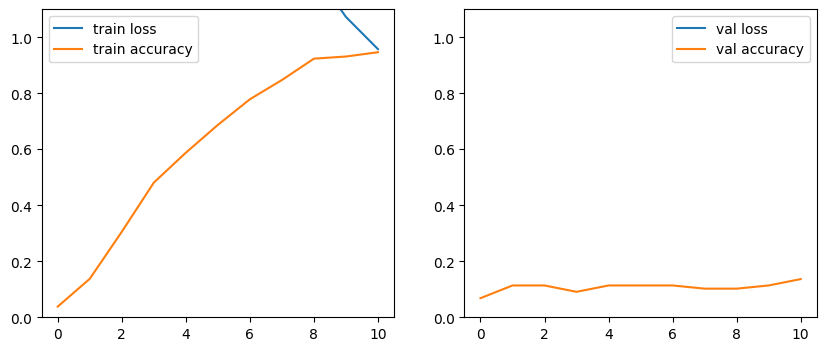

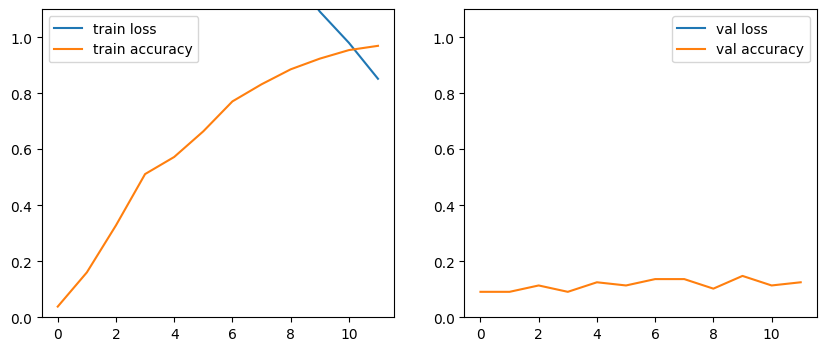

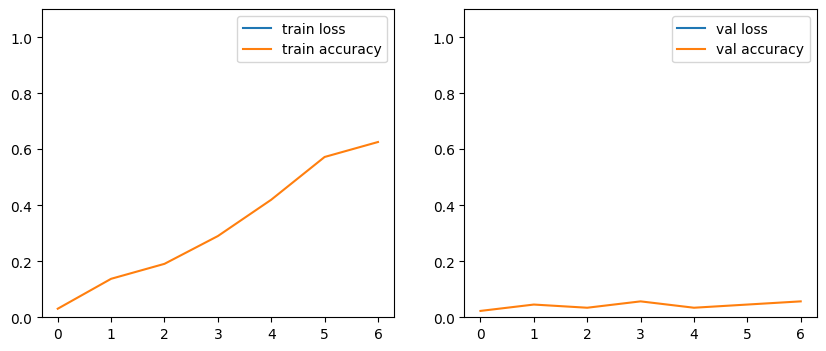

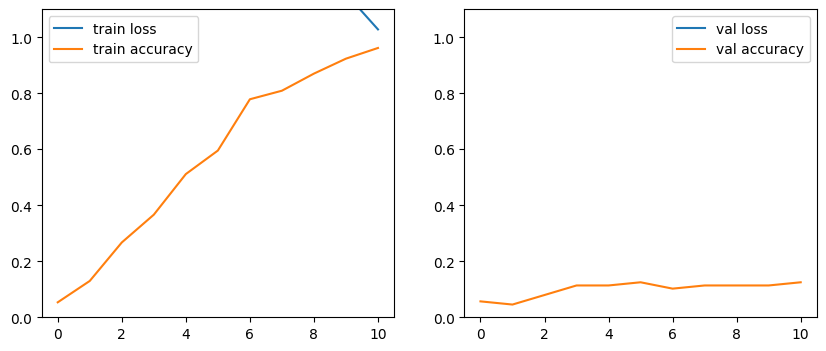

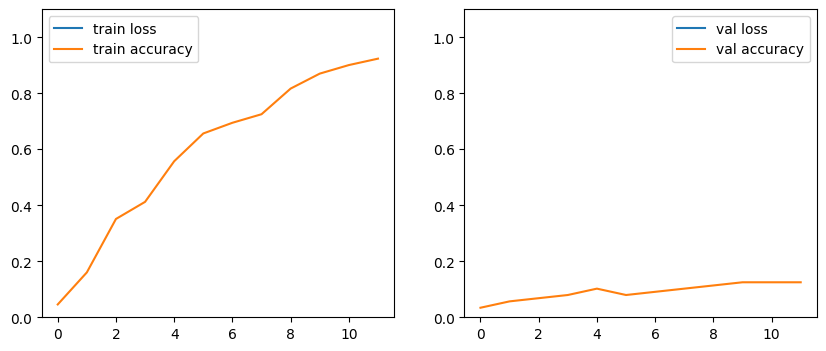

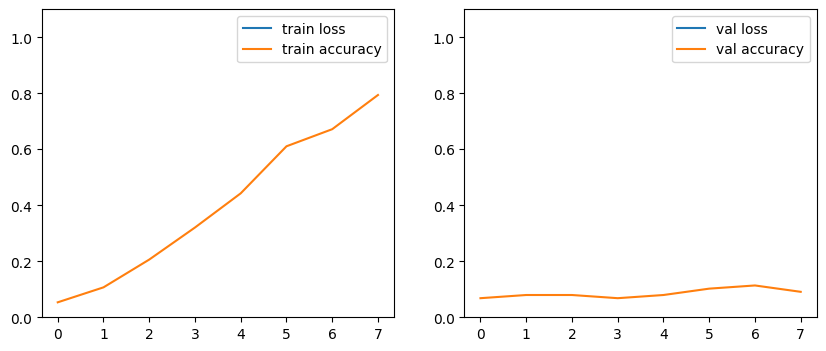

In [ ]:
for j in range (0,6):

    # Get X_preprocessed
    X_preprocessed = dict_preprocessors[results['model'][j]](X)

    # Get X_features
    X_features = []
    for i in range(len(X_preprocessed)):
        features = dict_models[results['model'][j]].predict(X_preprocessed[i], verbose=0)
        X_features.append(features)
    print(f"✅ (Run {j+1}) got X_features")

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_features, y, train_size=0.6, random_state=42, stratify=y)
    X_train = tf.convert_to_tensor(X_train)
    X_val = tf.convert_to_tensor(X_val)

    # Define RNN and compile
    model = model_initialize_simple(results['input_shape'][j].astype(int))
    model = model_compile(model)
    print(f"✅ (Run {j+1}) defined RNN and compile")

    # Model.fit and plot
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=8,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[es]
    )
    print(f"✅ (Run {j+1}) RNN is now fit")

    plot_accuracy(history)
    results['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)
    print(f"✅ {results['model'][j]} completed")

results


# 6. Train with rious RNN structures

### 6.1 Fix X_train, y_train with MobileNetV3Small

In [ ]:
# Get X_preprocessed
X_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(X)

# Get X_features
X_features = []
for i in range(len(X_preprocessed)):
    features = model_mobilenetv3small.predict(X_preprocessed[i], verbose=0)
    X_features.append(features)

# train-val split
X_train, X_val, y_train, y_val = train_test_split(X_features, y, train_size=0.6, random_state=42, stratify=y)
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(131, 10, 576)
(88, 10, 576)
(131, 20)
(88, 20)


### 6.2 Try out different RNN structures

In [ ]:
dim = 576


In [ ]:
def model_initialize_0(dim):
    model = Sequential()
    model.add(layers.SimpleRNN(units=256, activation="tanh", input_shape=(10,dim), return_sequences=True))
    model.add(layers.SimpleRNN(units=128, activation="tanh"))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model_simpleRNN = model_initialize_0(dim)
# model_simpleRNN


In [ ]:
def model_initialize_1(dim):
    model = Sequential()
    model.add(layers.SimpleRNN(units=512, activation="tanh", input_shape=(10,dim), return_sequences=True))
    model.add(layers.SimpleRNN(units=128, activation="tanh"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model_simpleRNN = model_initialize_1(dim)
# model_simpleRNN.summary()


In [ ]:
def model_initialize_LSTM(dim):
    model = Sequential()
    model.add(layers.LSTM(units=256, activation="tanh", dropout=0.3, recurrent_dropout=0.3, input_shape=(10,dim)))
    model.add(layers.Dense(units=128, activation="relu"))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model_LSTM = model_initialize_LSTM(dim)
# model_LSTM.summary()


In [ ]:
def model_initialize_LSTM2(dim):
    model = Sequential()
    model.add(layers.LSTM(units=512, activation="tanh", dropout=0.3, recurrent_dropout=0.3, input_shape=(10,dim)))
    model.add(layers.Dense(units=256, activation="relu"))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model_LSTM = model_initialize_LSTM2(dim)
# model_LSTM.summary()


In [ ]:
def model_initialize_GRU(dim):
    model = Sequential()
    model.add(layers.GRU(units=256, activation="tanh", dropout=0.3, recurrent_dropout=0.3, input_shape=(10,dim)))
    model.add(layers.Dense(units=128, activation="linear"))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(20, activation="softmax"))
    return model


In [ ]:
# Make a table to loop through
results2 = pd.DataFrame(columns=["model", "accuracy"])
results2["model"] = ("SimpleRNN", "SimpleRNN2", "LSTM1", "LSTM2", "GRU", "3D CNN")

results2


,model,accuracy
0,SimpleRNN,NaN
1,SimpleRNN2,NaN
2,LSTM1,NaN
3,LSTM2,NaN
4,GRU,NaN
5,3D CNN,NaN


In [ ]:
# Make a dictionary of models
dict_models_RNN = {
    "SimpleRNN": model_initialize_0(dim),
    "SimpleRNN2": model_initialize_1(dim),
    "LSTM1": model_initialize_LSTM(dim),
    "LSTM2": model_initialize_LSTM2(dim),
    "GRU": model_initialize_GRU(dim),
}


✅ (Run 1) defined RNN and compile
✅ (Run 1) RNN is now fit
✅ SimpleRNN completed
✅ (Run 2) defined RNN and compile
✅ (Run 2) RNN is now fit
✅ SimpleRNN2 completed
✅ (Run 3) defined RNN and compile
✅ (Run 3) RNN is now fit
✅ LSTM1 completed
✅ (Run 4) defined RNN and compile
✅ (Run 4) RNN is now fit
✅ LSTM2 completed
✅ (Run 5) defined RNN and compile
✅ (Run 5) RNN is now fit
✅ GRU completed


KeyError: '3D CNN'

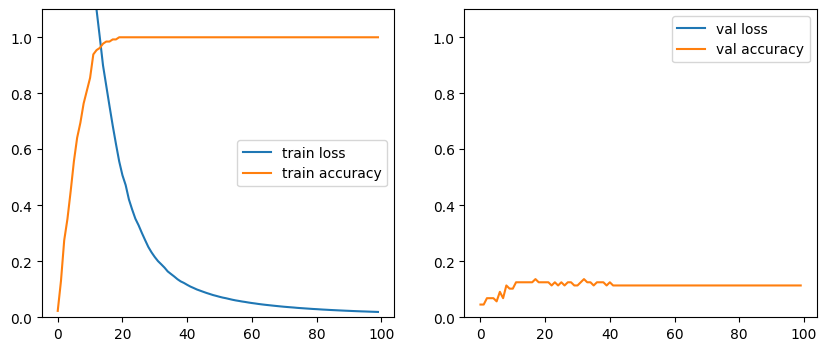

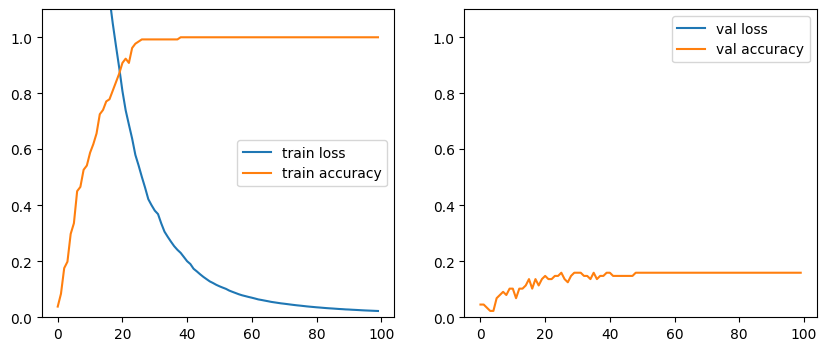

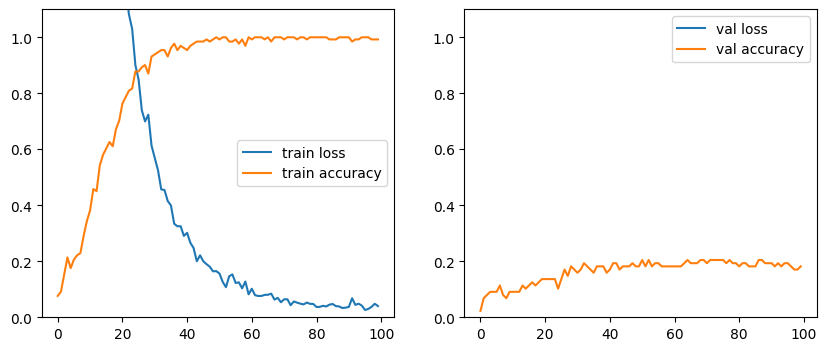

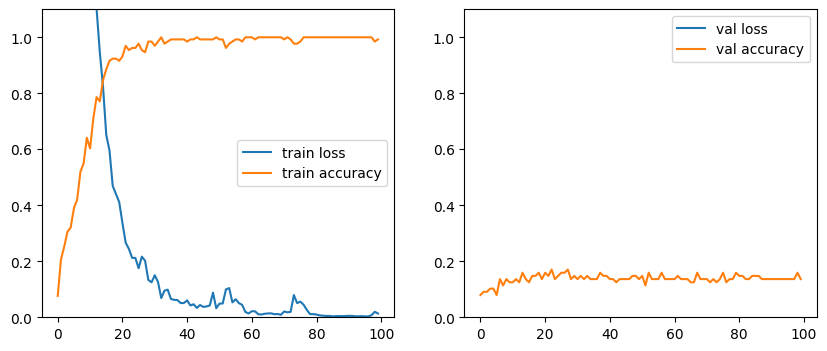

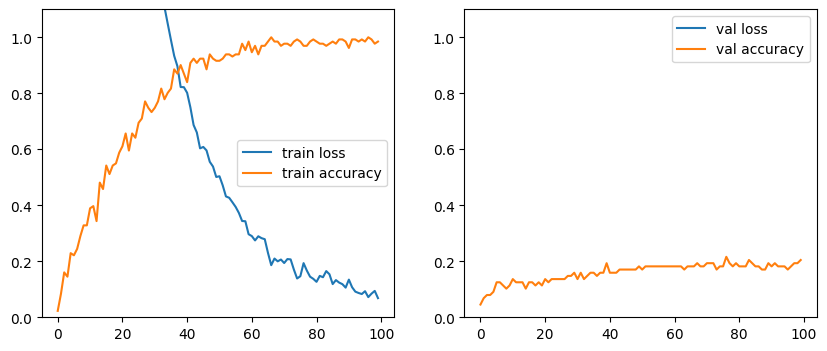

In [ ]:
for j in range (0,len(results2)):
# for j in range (3,4):

    # Define RNN and compile
    model = dict_models_RNN[results2['model'][j]]
    model = model_compile(model)
    print(f"✅ (Run {j+1}) defined RNN and compile")

    # Model.fit and plot
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=8,
        validation_data=(X_val, y_val),
        verbose=0
    )
    print(f"✅ (Run {j+1}) RNN is now fit")

    plot_accuracy(history)
    results2['accuracy'][j] = round(history.__dict__["history"]["val_accuracy"][-1],3)
    print(f"✅ {results2['model'][j]} completed")

results2


### 6.3 Try out with 3D CNNs

In [ ]:
X_CNN = X/255.

X_CNN_train, X_CNN_val, y_CNN_train, y_CNN_val = train_test_split(X_CNN, y, train_size=0.6, random_state=42)
X_CNN.shape


(219, 10, 150, 150, 3)

In [ ]:
input_shape_3DCNN = (10, 150, 150, 3)

def create_3d_cnn_model():
    model = Sequential()

    model.add(layers.Conv3D(64, kernel_size=(3,3,3), activation='relu', input_shape=input_shape_3DCNN))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.Conv3D(32, kernel_size=(3,3,3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(20, activation='softmax'))

    return model

model = create_3d_cnn_model()
model.summary()


Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 8, 148, 148, 64)   5248      
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 4, 74, 74, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 2, 72, 72, 32)     55328     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 1, 36, 36, 32)    0         
 g3D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 41472)             0         
                                                                 
 dense_208 (Dense)           (None, 10)             

In [ ]:
# Define 3D CNN and compile
model = create_3d_cnn_model()
model = model_compile(model)

es = EarlyStopping(patience=2, restore_best_weights=True)

# Model.fit and plot
history = model.fit(
    X_CNN_train,
    y_CNN_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_CNN_val, y_CNN_val),
    verbose=1,
    callbacks=[es]
)

plot_accuracy(history)
print(round(history.__dict__["history"]["val_accuracy"][-1],3))


NameError: name 'create_3d_cnn_model' is not defined